## Sentiment Analysis for Korean Movie Review Data

- 같은 Bag of Words model입니다. 이번에는 단어를 Word2Vec을 이용해 100차원에 임베딩한 뒤 분류 문제를 풀어보겠습니다.

## 1. Load Pickle File

In [1]:
import pickle

with open("movie_data.pickle", "rb") as f:
    movie_data = pickle.load(f)

In [2]:
movie_data.keys()

dict_keys(['reviews', 'scores', 'reviews_ix', 'word2ix', 'ix2word', 'max_seq_length'])

In [3]:
reviews = movie_data["reviews"]
scores = movie_data["scores"]
reviews_ix = movie_data["reviews_ix"]
word2ix = movie_data["word2ix"]
ix2word = movie_data["ix2word"]
max_seq_length = movie_data["max_seq_length"]

## 2. Build Word2Vec

In [4]:
from gensim.models import Word2Vec

# reviews의 단어들을 100차원에 embedding합니다. window size = 5입니다.
model = Word2Vec(reviews, size=100, window=5, min_count=3, sg=1, workers=4, iter=50)
model.save("word2vec.model")

## 3. Word2Vec Visualization

https://github.com/Chogyuwon/Study/blob/master/word2vec/word2vec_visualization.ipynb

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
from pprint import pprint

random.seed(777)

model = Word2Vec.load('word2vec.model')

In [6]:
keyword = "감동/Noun"
sim_list = model.most_similar(keyword, topn=10)
pprint(sim_list)

[('있어요/Adjective', 0.7123876214027405),
 ('였네요/Verb', 0.7054340839385986),
 ('적이네요/Verb', 0.6933397054672241),
 ('갖춘/Verb', 0.6790401935577393),
 ('!/Punctuation', 0.6644366979598999),
 ('~/Punctuation', 0.6503181457519531),
 ('질/Noun', 0.6289473176002502),
 ('세대/Noun', 0.6096614599227905),
 ('보았어요/Verb', 0.6057620048522949),
 ('좋아요/Adjective', 0.5890161991119385)]


/home/gyuwonable/anaconda3/envs/tf19/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/gyuwonable/anaconda3/envs/tf19/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


/home/gyuwonable/anaconda3/envs/tf19/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


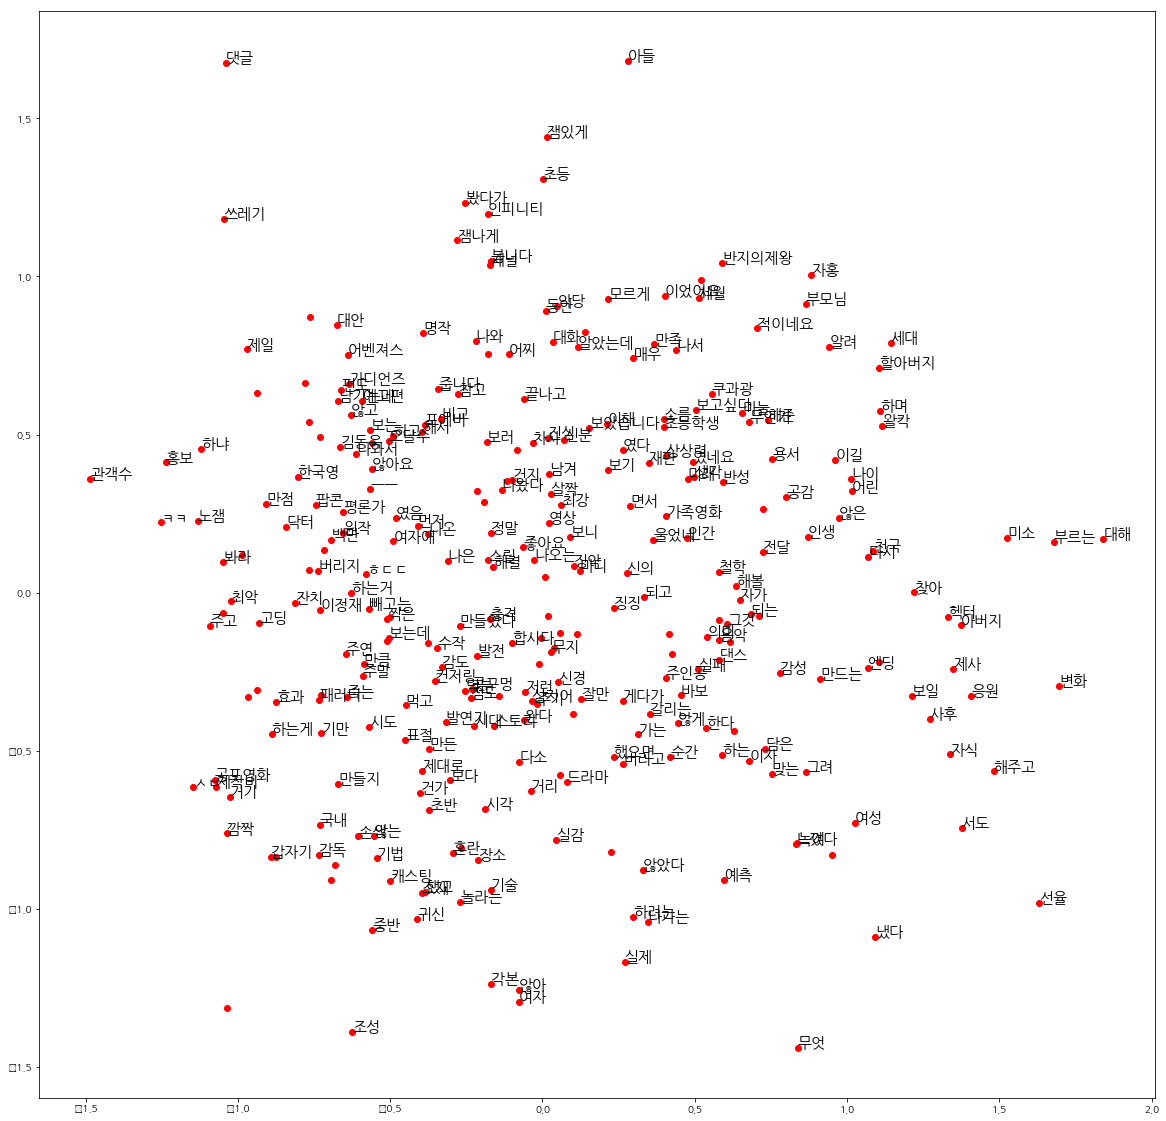

In [7]:
# 100차원에 임베딩 된 단어들을 2차원으로 축소한 뒤 그래프로 나타내 보겠습니다.

num_samples = 300
word_list = random.sample(list(model.wv.vocab.keys()), num_samples)
# word_list = list(model.wv.vocab.keys())
embeddings = [model[word] for word in word_list]

pca = PCA(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(20, 20))
plt.scatter(pca[:,0],pca[:,1], c="r")
for i, txt in enumerate(word_list):
    text = txt.split("/")
    if len(text[0]) > 1:
        plt.annotate(text[0], (pca[i,0], pca[i,1]), size=15)
plt.show()

## 4. Prepare Trian / Test Datasets

In [8]:
def pad_sequence(seq, max_seq_length):
    if len(seq) < max_seq_length:
        seq += [word2ix.get("<PAD>")]*(max_seq_length-len(seq))
    return seq

print(len(reviews_ix[0]))
print(len(pad_sequence(reviews_ix[0], max_seq_length)))

reviews_ix = [pad_sequence(reviews_ix[i], max_seq_length) for i in range(len(reviews_ix))] 

4
113


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_ix, 
                                                    scores, 
                                                    test_size=0.3, 
                                                    random_state=777)

In [10]:
len(reviews_ix)

1827

In [11]:
len(X_train)

1278

In [12]:
len(X_test)

549

## 4. Prepare Embedding Matrix

In [13]:
import numpy as np
import torch

embedding_matrix = []

for word in word2ix.keys():
    try:
        embedding_matrix.append(model[word])
    except:
        embedding_matrix.append(np.zeros(100))

print(len(word2ix))
print(len(embedding_matrix))

embedding_matrix = torch.Tensor(embedding_matrix)

5982
5982


/home/gyuwonable/anaconda3/envs/tf19/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [14]:
embedding_matrix[0] #<PAD>

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
index = 12
print(ix2word[index])
print(embedding_matrix[index])
print(model[ix2word[index]])

자가/Noun
tensor([ 0.0457,  0.2863,  0.1584, -0.2280,  0.3399,  0.5188, -0.1892,  0.0012,
         0.0902,  0.0804,  0.0565,  0.0179,  0.1807,  0.2784, -0.0129,  0.0499,
         0.1685,  0.0106,  0.1513, -0.0043, -0.4650,  0.1250,  0.4412, -0.1720,
        -0.1823,  0.5343, -0.0155,  0.4647, -0.0782, -0.1674,  0.0878,  0.2256,
        -0.3060, -0.2599, -0.3809,  0.0017, -0.2124, -0.1787, -0.3202, -0.1626,
         0.0439, -0.0524,  0.1458, -0.2895,  0.3095, -0.4761,  0.1152, -0.2603,
        -0.1557,  0.0177, -0.1418, -0.0305,  0.0217,  0.5578,  0.1623, -0.0064,
         0.2204, -0.3902, -0.0899, -0.0673,  0.0064, -0.3541,  0.1090,  0.2966,
        -0.0477,  0.2387, -0.4078, -0.0144,  0.0955, -0.3711,  0.1420,  0.2721,
         0.0743, -0.1678, -0.0891, -0.0016,  0.3909, -0.2036,  0.0517,  0.1920,
         0.0964,  0.1253,  0.1749, -0.2563, -0.1837, -0.2182,  0.2514, -0.2555,
         0.1615,  0.1022,  0.1005,  0.2121, -0.4298, -0.0241,  0.1238,  0.0650,
        -0.0466, -0.1136, -0.107

/home/gyuwonable/anaconda3/envs/tf19/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


## 5. Modeling

#### 3. BoW + nn.Embedding + word2vec
https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding.from_pretrained

In [16]:
import torch
import torch.nn as nn
#import torch.nn.functional as F
#from torch.autograd import Variable
import torch.optim as optim
torch.manual_seed(777);

In [17]:
torch.cuda.is_available()

True

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
reviews_ix[0]

[1512,
 2279,
 1491,
 4296,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [20]:
class BoW_Clf_Embed_mean(nn.Module):
    def __init__(self, vocab_size, embedding_size, output_size, embedding_matrix):
        super(BoW_Clf_Embed_mean, self).__init__()
        
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # True is Default        
        self.linear = nn.Linear(embedding_size, output_size)
    
    def forward(self,inputs):
        
        embed = self.embed(inputs)
        embed_mean = torch.mean(embed, 1)
        out = self.linear(embed_mean)
        
        return out

In [21]:
EPOCHS = 5000
LR = 0.01

model = BoW_Clf_Embed_mean(len(word2ix),100, 11, embedding_matrix).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=LR, momentum=0.9)

for epoch in range(EPOCHS):

    model.zero_grad()
    inputs = torch.LongTensor(X_train).to(device)
    targets = torch.LongTensor(y_train).to(device)
    
    preds = model(inputs)
    
    loss = loss_function(preds, targets)

    if epoch % 500 == 0:
        print(loss.item())
    
    loss.backward()
    optimizer.step()

2.3907065391540527
2.0409300327301025
2.036137104034424
2.0320780277252197
2.0284698009490967
2.025146722793579
2.0220017433166504
2.018967628479004
2.0160014629364014
2.013076066970825


In [22]:
correct = 0
model.eval()
for i, seq in enumerate(X_test):
    
    input = torch.LongTensor(seq).view(1,-1).to(device)
    pred = model(input)
    _, pred = torch.max(pred, 1)
    true = y_test[i]
    
    if true == pred.item():
        correct +=1
    
    if i%100 == 0:
        input_seq = [ix2word.get(ix) for ix in seq if ix != 0]
        print("Input :", input_seq)
        print("Prediction :", pred.item())
        print("Truth :", y_test[i])
        print("\n")

print("Accuracy :", (correct/len(X_test)*100))

Input : ['후반/Noun', '쫄렸다/Noun']
Prediction : 10
Truth : 9


Input : ['감동/Noun', '영화/Noun', '보고/Noun', '운/Noun', '거의/Noun', '애니메이션/Noun', '보면서/Verb', '울줄/Verb', '몰랐네요/Verb', 'ㅜ/KoreanParticle', '감동/Noun', 'ㅜㅜ/KoreanParticle']
Prediction : 10
Truth : 10


Input : ['스토리/Noun', '별로/Noun', '노래/Noun']
Prediction : 10
Truth : 8


Input : ['히어로/Noun', '물/Noun', '찍어도/Verb', '될/Verb', '정도/Noun', '그래픽/Noun', '본/Verb', '한국영/Noun', '화의/Noun', '희망/Noun', '이야기/Noun', '거기/Noun']
Prediction : 10
Truth : 5


Input : ['보통/Noun', '서로/Noun', '아는/Verb', '상황/Noun', '주먹/Noun', '메/Noun', '쳐서/Verb', '다른/Noun', '격방/Noun', '시도/Noun', '하는게/Verb', '정상/Noun', '로메/Noun', '쳐/Verb', '대는게/Verb', '인상/Noun', '또/Noun', '와칸/Noun', '다인/Noun', '가에서/Verb', '개때/Noun', '닥치는데/Verb', '굳이/Noun', '칼/Noun', '빼/Noun', '일일이/Noun', '상대/Noun', '하는것도/Verb', '졸/Noun', '인상/Noun', '과거/Noun', '마징/Noun', '가가/Noun', '싸우다가/Verb', '죽기/Verb', '직전/Noun', '가슴/Noun', '원자력/Noun', '빔/Noun', '쏴서/Verb', '이기는거/Verb', '배운듯/Verb']
Prediction : 10
Truth : 0
